## This Notebook Demonstrates:
1. Reading the data in python, preparing it for analysis, and adjusting the labels to contain underscores
2. The code that simplfies a Raw drawing to the Simplified drawing
3. How to make a submission file with predictions in the required format

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("/content/drive/My Drive/Colab Notebooks/part1/input"))
print(os.listdir("/content/drive/My Drive/Colab Notebooks/part1/input/train"))

# Any results you write to the current directory are saved as output.

['demo.csv', '_DS_Store', 'test.csv', 'test_ans.csv', 'valid.csv', 'train']
['_DS_Store', 'bear.csv', 'bed.csv', 'bee.csv', 'belt.csv', 'cactus.csv', 'cake.csv', 'coffee cup.csv', 'door.csv', 'fork.csv', 'giraffe.csv', 'hand.csv', 'key.csv', 'laptop.csv', 'light bulb.csv', 'marker.csv', 'paintbrush.csv', 'popsicle.csv', 'raccoon.csv', 'rain.csv', 'roller coaster.csv', 'snail.csv', 'spoon.csv', 'swan.csv', 'The Great Wall of China.csv', 'toaster.csv', 'train.csv', 'whale.csv', 'wine bottle.csv', 'banana.csv', 'bandage.csv']


In [0]:
import warnings
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import ast
import math

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Let's read some of the training data

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/part1/input/train/roller coaster.csv',
                   index_col=0,
                   nrows=10)
data.head()

,drawing,word
0,"[[[0, 28, 50, 73, 88, 94, 101, 101, 98, 100, 1...",roller coaster
1,"[[[0, 50, 78, 126, 142, 152, 157, 157, 141, 12...",roller coaster
2,"[[[2, 0, 17, 42, 68, 97, 120, 140, 151, 151, 1...",roller coaster
3,"[[[192, 130, 101, 72, 0], [4, 99, 132, 148, 17...",roller coaster
4,"[[[9, 11, 19, 41, 114, 136, 153, 167, 179, 230...",roller coaster


### Fixing labels


In [0]:
data['word'] = data['word'].replace(' ', '_', regex=True)
data.head()

,drawing,word
0,"[[[0, 28, 50, 73, 88, 94, 101, 101, 98, 100, 1...",roller_coaster
1,"[[[0, 50, 78, 126, 142, 152, 157, 157, 141, 12...",roller_coaster
2,"[[[2, 0, 17, 42, 68, 97, 120, 140, 151, 151, 1...",roller_coaster
3,"[[[192, 130, 101, 72, 0], [4, 99, 132, 148, 17...",roller_coaster
4,"[[[9, 11, 19, 41, 114, 136, 153, 167, 179, 230...",roller_coaster


# Let's look at some images
We're going to grab the some images from the `demo.csv` file. Since the `word` values are read as a string, we need to convert them to a list using the `ast.literal_eval` function.

In [0]:
test_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/part1/input/demo.csv') #既有的圖像
first_ids = test_raw.iloc[:5].index
images = [ast.literal_eval(lst) for lst in test_raw.loc[first_ids, 'drawing'].values] #抓取1~5的drawing value

## Viewing  Drawings

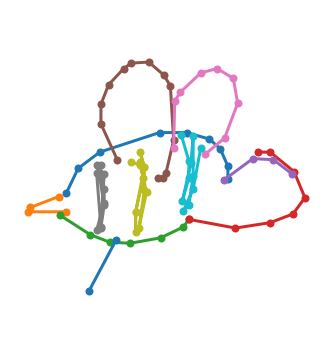

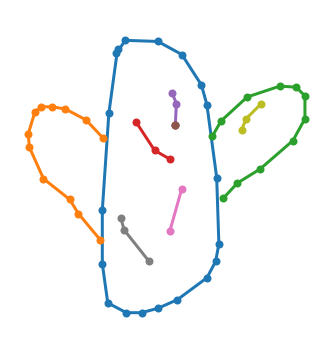

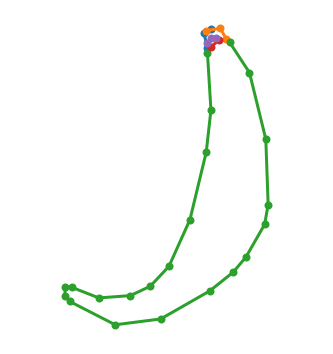

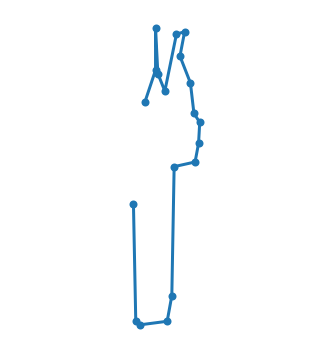

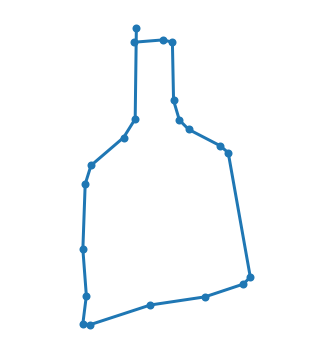

In [0]:
for index, drawing in enumerate(images, 0):  #做不同的figure(視窗)來放置那五個圖片
    
    plt.figure(figsize=(6,3))  #開視窗大小
    for x,y in drawing:  
        plt.subplot(1,2,1)  #將不同的小框放在同個視窗(一行兩列)
        plt.plot(x, y, marker='.') #用點畫出座標點
        plt.axis('off')  #關閉座標軸


    plt.gca().invert_yaxis()  #反轉y座標軸
    plt.axis('equal')  #x,y軸有相同長度
    plt.show()  

## Model training

In [0]:
import os
#  revise for mac os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [0]:
test_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/part1/input/demo.csv') #既有的圖像
numstonames = {i: v[58:-4].replace(" ", "_") for i, v in enumerate(class_paths)}  #改path name進到 numstonames ((竟然是用算的.....
print(numstonames)
namestonums = {v:k for k,v in numstonames.items()}  #將這些名字作為項目

num_classes = 30
imheight, imwidth = 64, 64  #image
ims_per_class = 3000  #取樣數

def draw_it(strokes):
    image = Image.new("P", (64,64), color=255)  #"P" means the 8bit colors (it can also use RGB or others...)
    image_draw = ImageDraw.Draw(image) 
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.
    #作圖

{0: 'bear', 1: 'bed', 2: 'bee', 3: 'belt', 4: 'cactus', 5: 'cake', 6: 'coffee_cup', 7: 'door', 8: 'fork', 9: 'giraffe', 10: 'hand', 11: 'key', 12: 'laptop', 13: 'light_bulb', 14: 'marker', 15: 'paintbrush', 16: 'popsicle', 17: 'raccoon', 18: 'rain', 19: 'roller_coaster', 20: 'snail', 21: 'spoon', 22: 'swan', 23: 'The_Great_Wall_of_China', 24: 'toaster', 25: 'train', 26: 'whale', 27: 'wine_bottle', 28: 'banana', 29: 'bandage'}


In [0]:
train_grand = []

for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, nrows=ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
#less memory than np.concatenate
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) 
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

100%|██████████| 30/30 [01:46<00:00,  3.49s/it]


In [0]:
# valfrac = 0.1
# cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[:, 0], train_grand[:, 1:]

valid = pd.read_csv('/content/drive/My Drive/Colab Notebooks/part1/input/valid.csv',nrows = ims_per_class)
imagebag = bag.from_sequence(valid.drawing.values).map(draw_it)
validarray = np.array(imagebag.compute())
validarray = np.reshape(validarray, (validarray.shape[0], imheight, imwidth, 1))

X_val = validarray
y_val = [namestonums[w.replace(" ", "_") ] for w in valid.word]

# del train_grand


y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________

In [0]:
import time
starttime = time.time()

In [0]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=5) 
callbacks = [reduceLROnPlat, earlystop]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

model.fit(x=X_train, y=y_train,
          batch_size = 32,
          epochs = 22,
          validation_data = (X_val, y_val),
          callbacks = callbacks,
          verbose = 1)
endtime = time.time()

Train on 90000 samples, validate on 3000 samples
Epoch 1/22
90000/90000 [==============================] - 53s 585us/sample - loss: 2.5795 - acc: 0.2696 - top_3_accuracy: 0.4817 - val_loss: 2.4231 - val_acc: 0.2947 - val_top_3_accuracy: 0.5427
Epoch 2/22
90000/90000 [==============================] - 49s 541us/sample - loss: 2.2985 - acc: 0.3401 - top_3_accuracy: 0.5665 - val_loss: 2.3164 - val_acc: 0.3317 - val_top_3_accuracy: 0.5693
Epoch 3/22
90000/90000 [==============================] - 49s 546us/sample - loss: 2.1259 - acc: 0.3828 - top_3_accuracy: 0.6102 - val_loss: 2.3064 - val_acc: 0.3283 - val_top_3_accuracy: 0.5680
Epoch 4/22
90000/90000 [==============================] - 49s 542us/sample - loss: 1.9185 - acc: 0.4351 - top_3_accuracy: 0.6613 - val_loss: 2.3332 - val_acc: 0.3313 - val_top_3_accuracy: 0.5720
Epoch 5/22
90000/90000 [==============================] - 49s 542us/sample - loss: 1.6966 - acc: 0.4967 - top_3_accuracy: 0.7096 - val_loss: 2.4463 - val_acc: 0.3260 - val

## Model prediction

In [0]:
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/part1/input/demo.csv')[['drawing']]
imagebag = bag.from_sequence(test.drawing.values).map(draw_it)
testarray = np.array(imagebag.compute())
testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
testpreds = model.predict(testarray, verbose=0)
ttvs = np.argsort(-testpreds)

In [0]:
for idx in ttvs[:,[0,1,2]]:
    print(numstonames[idx[0]])
    print(numstonames[idx[1]])
    print(numstonames[idx[2]])
    print('----------')

giraffe
banana
swan
----------
hand
swan
cactus
----------
giraffe
banana
swan
----------
paintbrush
fork
wine_bottle
----------
wine_bottle
laptop
train
----------


## Preprocessing the generating data and predict

In [0]:
graph = pd.read_csv('/content/drive/My Drive/Colab Notebooks/part1/output.csv',header=None)
grapharray = np.array(graph)
grapharray = np.where(grapharray[:] > 0.2,1,0)
grapharray = np.reshape(grapharray, (1,imheight, imwidth, 1))
graphpreds = model.predict(grapharray, verbose=0)
gvs = np.argsort(-graphpreds)


for idx in gvs[:]:
    for i in idx:
        print(numstonames[i])


rain
The_Great_Wall_of_China
belt
train
cake
bandage
key
roller_coaster
spoon
fork
whale
bear
raccoon
giraffe
marker
swan
paintbrush
banana
coffee_cup
wine_bottle
light_bulb
bed
snail
bee
toaster
laptop
door
cactus
hand
popsicle


## Making a Submission

In [0]:
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/part1/input/test.csv')[['drawing']]
imagebag = bag.from_sequence(test.drawing.values).map(draw_it)
testarray = np.array(imagebag.compute())
testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
testpreds = model.predict(testarray, verbose=0)
ttvs = np.argsort(-testpreds)



predict_label = [numstonames[ttvs[i][0]] for i in range(ttvs.shape[0])]

test['word'] = predict_label
test.to_csv('/content/drive/My Drive/Colab Notebooks/part1/test_predict.csv')